# **IMPORTAÇÃO DE BIBLIOTECAS**

In [38]:
### BIBLIOTECAS UTILIZADAS NA ETAPA DE MACHINE LEARNING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings('ignore')

## PRÉ-PROCESSAMENTO DOS DADOS

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean
from numba import njit

## RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## SARIMA
import statsmodels as sm
from pmdarima import auto_arima

## LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# **IMPORTAÇÃO DOS DADOS FINAIS**

In [46]:
### IMPORTAÇÃO DOS DADOS FINAIS
path_combs = r'C:\Users\Emanuel\Desktop\PUCMG\TCC\Dataframes'

files = glob.glob(path_combs + '/*.csv')
many_dfs = [pd.read_csv(file, sep=',') for file in files]
df_fuels = pd.concat(many_dfs, ignore_index=False)

df_fuels['data'] = pd.to_datetime(df_fuels['data'])
df_fuels['tipo_comb'] = df_fuels['tipo_comb'].astype('string')

# **PRÉ-PROCESSAMENTO DOS DADOS PARA MODELAGEM**

## FEATURES E SPLIT: VARIÁVEIS & TARGET

In [47]:
## RENOMEANDO AS COLUNAS DE DATA, VARIÁVEL TARGET E IDENTIFICADOR DA SÉRIE TEMPORAL PARA SE ADEQUAR AO MLFORECAST
df_fuels = df_fuels.rename(columns={'data': 'ds', 'preco_medio': 'y', 'tipo_comb': 'unique_id'})

In [48]:
## DEFININDO OS OBJETOS PARA CÁLCULO DAS FEATURES COMO DIFERENÇA, LAGS E MÉDIA MÓVEL

### FUNÇÃO DE DIFERENCIAÇÃO DEFINIDA UTILIZANDO O NUMBA (ADEQUADO AO MLFORECAST)
@njit
def difference(x, lag):
    diff_x = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        diff_x[i] = x[i] - x[i-lag]
    return diff_x

### OBJETO DO MLFORECAST PARA CÁLCULO DE FEATURES COMO LAGS, MÉDIA MÓVEL E VARIÁVEIS DE DATA
get_features = MLForecast(
    models=[],
    freq='D',
    lags=[1,7],
    lag_transforms={
        1: [RollingMean(window_size=3), RollingMean(window_size=7), (difference, 1), (difference, 7)]
    },
    date_features=['dayofweek', 'month', 'year', 'day'],
    num_threads=2
)

### APLICAÇÃO DO OBJETO NO DATAFRAME PARA OBTENÇÃO DAS FEATURES
df_fuels = get_features.preprocess(df_fuels, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

In [49]:
## SEPARAÇÃO DOS DATAFRAMES PARA CADA COMBUSTÍVEL E TAMBÉM DA VARIÁVEL TARGET

X_gasolina = df_fuels[df_fuels['unique_id'] == 'GASOLINA'].drop(columns=['y']).reset_index(drop=True)
X_etanol = df_fuels[df_fuels['unique_id'] == 'ETANOL'].drop(columns=['y']).reset_index(drop=True)
y_gasolina = df_fuels[df_fuels['unique_id'] == 'GASOLINA']['y'].reset_index(drop=True)
y_etanol = df_fuels[df_fuels['unique_id'] == 'ETANOL']['y'].reset_index(drop=True)

print(f"Número de dias na série temporal do ETANOL:\n{X_etanol.shape[0]} dias.\n")
print(f"Número de dias na série temporal do GASOLINA:\n{X_gasolina.shape[0]} dias.\n")
print(f"Número de variáveis independentes das duas séries:\n{X_etanol.shape[1]} colunas.")

Número de dias na série temporal do ETANOL:
622 dias.

Número de dias na série temporal do GASOLINA:
622 dias.

Número de variáveis independentes das duas séries:
20 colunas.


## SPLIT TREINO/TESTE COM CROSS-VALIDATION

In [50]:
### DIVISÃO EM TREINO E TESTE DOS DATAFRAMES DE COMBUSTÍVEIS SEGUINDO A ESTRATÉGIA DE VALIDAÇÃO CRUZADA DE SÉRIES TEMPORAIS
tscv = TimeSeriesSplit(n_splits=4, test_size=90)
folds_treino_gasolina, folds_treino_etanol = [], []
folds_teste_gasolina, folds_teste_etanol = [], []

for train_index, test_index in tscv.split(X_gasolina):
    folds_treino_gasolina.append(X_gasolina.iloc[train_index])
    folds_teste_gasolina.append(X_gasolina.iloc[test_index])

for train_index, test_index in tscv.split(X_etanol):
    folds_treino_etanol.append(X_etanol.iloc[train_index])
    folds_teste_etanol.append(X_etanol.iloc[test_index])

print("TREINO (GASOLINA e ETANOL)\n-----------------")
for i in range(len(folds_treino_gasolina)):
    fold_shape = folds_treino_gasolina[i].shape[0]
    data_inicio = folds_treino_gasolina[i]['ds'].min().date()
    data_fim = folds_treino_gasolina[i]['ds'].max().date()
    print(f"FOLD_{i}: {fold_shape} datas\tInicio: {data_inicio}\t   Fim: {data_fim}")

print("\nTESTE (GASOLINA e ETANOL)\n-----------------")
for i in range(len(folds_teste_gasolina)):
    fold_shape = folds_teste_gasolina[i].shape[0]
    data_inicio = folds_teste_gasolina[i]['ds'].min().date()
    data_fim = folds_teste_gasolina[i]['ds'].max().date()
    print(f"FOLD_{i}: {fold_shape} datas\tInicio: {data_inicio}\t   Fim: {data_fim}")

TREINO (GASOLINA e ETANOL)
-----------------
FOLD_0: 262 datas	Inicio: 2022-01-13	   Fim: 2023-01-13
FOLD_1: 352 datas	Inicio: 2022-01-13	   Fim: 2023-05-19
FOLD_2: 442 datas	Inicio: 2022-01-13	   Fim: 2023-09-22
FOLD_3: 532 datas	Inicio: 2022-01-13	   Fim: 2024-01-26

TESTE (GASOLINA e ETANOL)
-----------------
FOLD_0: 90 datas	Inicio: 2023-01-16	   Fim: 2023-05-19
FOLD_1: 90 datas	Inicio: 2023-05-22	   Fim: 2023-09-22
FOLD_2: 90 datas	Inicio: 2023-09-25	   Fim: 2024-01-26
FOLD_3: 90 datas	Inicio: 2024-01-29	   Fim: 2024-05-31


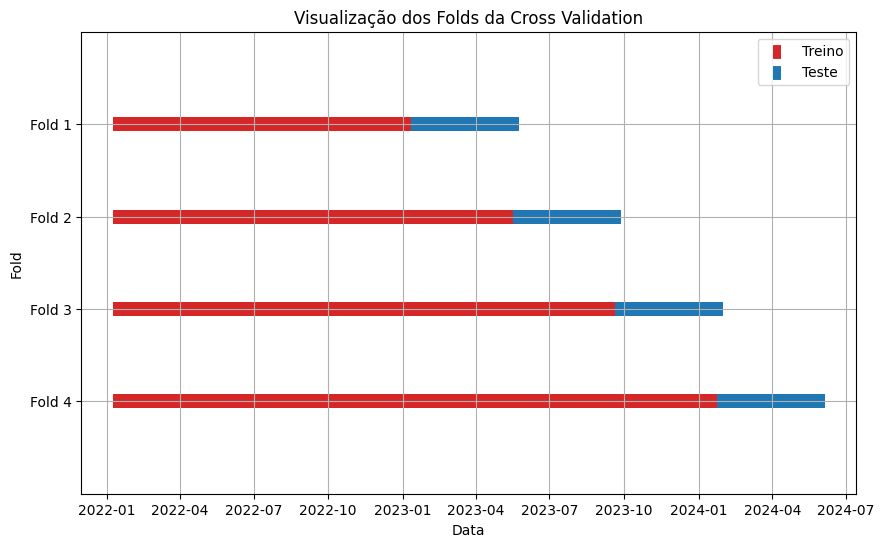

In [51]:
### FUNÇÃO PARA PLOTAR OS FOLDS OBTIDOS COM O SPLIT
def plot_cross_valid(cv_obj, X, y, datas, ax):

    n_splits = cv_obj.get_n_splits()
    
    for i, (train_index, test_index) in enumerate(cv_obj.split(X)):
        ax.scatter(datas[train_index], [i + 0.5] * len(train_index), c='tab:red', marker='_', lw=10, label='Treino' if i == 0 else "")
        ax.scatter(datas[test_index], [i + 0.5] * len(test_index), c='tab:blue', marker='_', lw=10, label='Teste' if i == 0 else "")
    
    ax.set(ylim=[n_splits + 0.5, -0.5], title='Visualização dos Folds da Cross Validation', xlabel='Data', ylabel='Fold')
    ax.legend(loc='best')
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels([f'Fold {i + 1}' for i in range(n_splits)])
    ax.grid(True)
    return ax

### PLOT DOS FOLDS OBTIDOS COM O SPLIT
fig, ax = plt.subplots(figsize=(10, 6))
datas = X_gasolina['ds']
plot_cross_valid(tscv, X_gasolina, y_gasolina, datas, ax)
plt.show()

# **TREINAMENTO DOS MODELOS USANDO CROSS-VALIDATION**

In [52]:
### REMOÇÃO DE COLUNAS NÃO SUPORTADAS PELOS MODELOS: DATA E STRING
X_etanol.drop(columns=['ds', 'unique_id'], inplace=True)
X_gasolina.drop(columns=['ds', 'unique_id'], inplace=True)

## ARIMA

### ETANOL

In [36]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_etanol = []
preco_etanol_real = []
preco_etanol_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_etanol):
    X_etanol_train, X_etanol_test = X_etanol.iloc[train_index], X_etanol.iloc[test_index]
    y_etanol_train, y_etanol_test = y_etanol.iloc[train_index], y_etanol.iloc[test_index]

    ### TREINAMENTO DO MODELO
    model = auto_arima(y = y_etanol_train, X = X_etanol_train, m = 7)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_etanol = model.predict(n_periods = len(X_etanol_test), X = X_etanol_test)
    rmse = mean_squared_error(y_etanol_test, y_pred_etanol, squared=False)
    print(f"RMSE do FOLD_{i}: {rmse}")
    rmse_scores_etanol.append(rmse)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_etanol_real.extend(y_etanol_test)
    preco_etanol_pred.extend(y_pred_etanol)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_etanol)}")

c:\Users\Emanuel\anaconda3\envs\my_venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE do FOLD_0: 0.06739947530540295


c:\Users\Emanuel\anaconda3\envs\my_venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE do FOLD_1: 0.07038075736022822


c:\Users\Emanuel\anaconda3\envs\my_venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE do FOLD_2: 0.059695436388491056
RMSE do FOLD_3: 0.09866334095759868

Média dos RMSEs: 0.07403475250293023


c:\Users\Emanuel\anaconda3\envs\my_venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


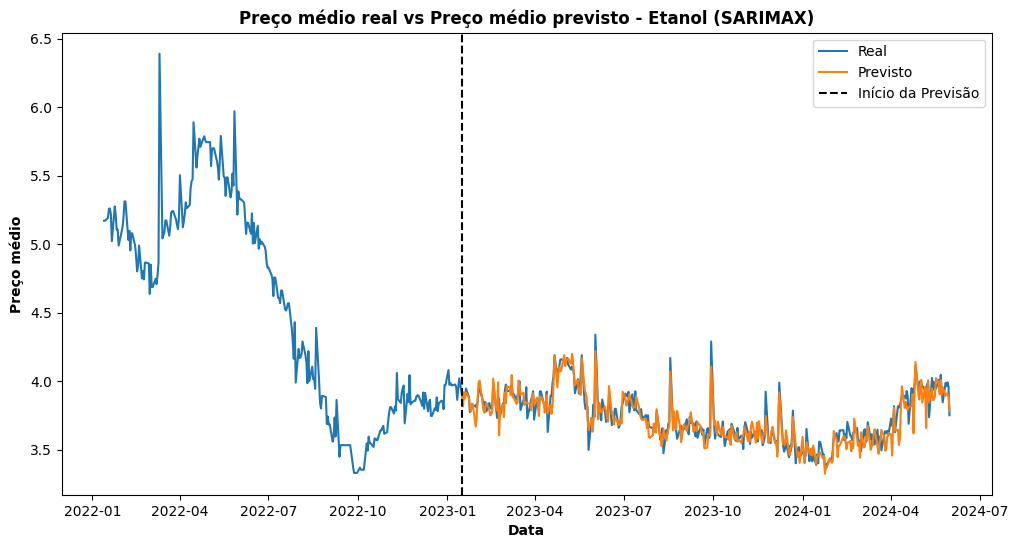

In [40]:
datas_pred_etanol = pd.concat(fold['ds'] for fold in folds_teste_etanol)  
resultados_etanol = pd.DataFrame({
    'data': datas_pred_etanol,
    'real': preco_etanol_real,
    'prediction': preco_etanol_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'ETANOL']['ds'], y_etanol, label='Real')
plt.plot(resultados_etanol['data'], resultados_etanol['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_etanol['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Etanol (SARIMAX)', fontweight='bold')
plt.legend()
plt.show()

### GASOLINA

In [54]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_gasolina = []
preco_gasolina_real = []
preco_gasolina_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_gasolina):
    X_gasolina_train, X_gasolina_test = X_gasolina.iloc[train_index], X_gasolina.iloc[test_index]
    y_gasolina_train, y_gasolina_test = y_gasolina.iloc[train_index], y_gasolina.iloc[test_index]

    ### TREINAMENTO DO MODELO
    model = auto_arima(y = y_gasolina_train, X = X_gasolina_train, m = 7)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_gasolina = model.predict(n_periods = len(X_gasolina_test), X = X_gasolina_test)
    rmse = mean_squared_error(y_gasolina_test, y_pred_gasolina, squared=False)
    print(f"RMSE do FOLD_{i}: {rmse}")
    rmse_scores_gasolina.append(rmse)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_gasolina_real.extend(y_gasolina_test)
    preco_gasolina_pred.extend(y_pred_gasolina)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_gasolina)}")

RMSE do FOLD_0: 0.06982764874636432
RMSE do FOLD_1: 0.08185390411885334
RMSE do FOLD_2: 0.08984259423324045
RMSE do FOLD_3: 0.06957875109755604

Média dos RMSEs: 0.07777572454900354


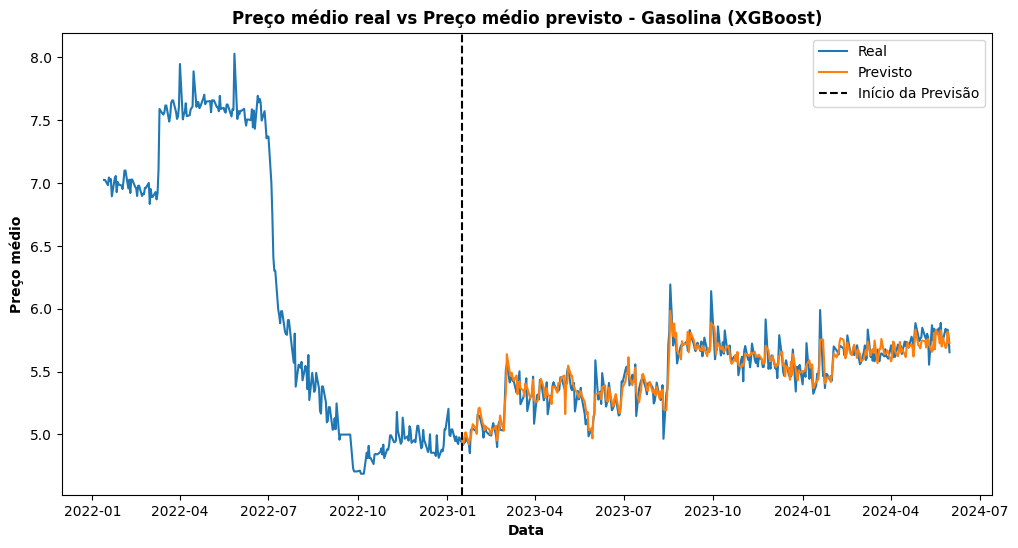

In [55]:
### DATAFRAME PARA AVALIAÇÃO DOS RESULTADOS

datas_pred_gasolina = pd.concat(fold['ds'] for fold in folds_teste_gasolina)  
resultados_gasolina = pd.DataFrame({
    'data': datas_pred_gasolina,
    'real': preco_gasolina_real,
    'prediction': preco_gasolina_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'GASOLINA']['ds'], y_gasolina, label='Real')
plt.plot(resultados_gasolina['data'], resultados_gasolina['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_gasolina['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Gasolina (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

## RANDOM FOREST

In [63]:
params_rf = {
    'n_estimators': 1000,
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 10
}

rf_model_g = RandomForestRegressor(**params_rf)
rf_model_e = RandomForestRegressor(**params_rf)

### ETANOL

In [64]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_etanol = []
preco_etanol_real = []
preco_etanol_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_etanol):
    X_etanol_train, X_etanol_test = X_etanol.iloc[train_index], X_etanol.iloc[test_index]
    y_etanol_train, y_etanol_test = y_etanol.iloc[train_index], y_etanol.iloc[test_index]

    ### TREINAMENTO DO MODELO
    rf_model_e.fit(X_etanol_train, y_etanol_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_etanol = rf_model_e.predict(X_etanol_test)
    rmse = mean_squared_error(y_etanol_test, y_pred_etanol, squared=False)
    print(f"RMSE do FOLD_{i}: {rmse}")
    rmse_scores_etanol.append(rmse)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_etanol_real.extend(y_etanol_test)
    preco_etanol_pred.extend(y_pred_etanol)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_etanol)}")

RMSE do FOLD_0: 0.08052113925784392
RMSE do FOLD_1: 0.11719049265994809
RMSE do FOLD_2: 0.09384246089741297
RMSE do FOLD_3: 0.07192125614032092

Média dos RMSEs: 0.09086883723888146


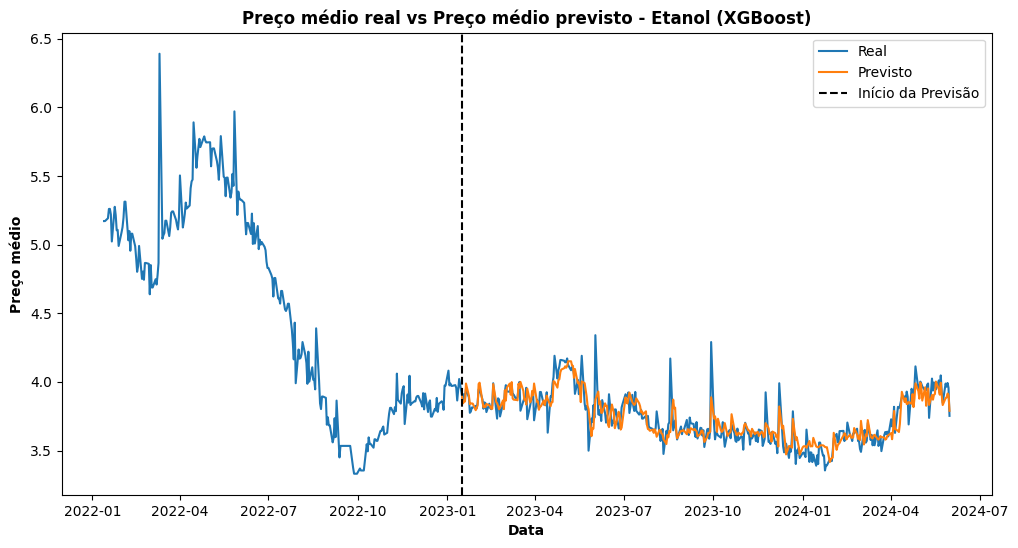

In [65]:
datas_pred_etanol = pd.concat(fold['ds'] for fold in folds_teste_etanol)  
resultados_etanol = pd.DataFrame({
    'data': datas_pred_etanol,
    'real': preco_etanol_real,
    'prediction': preco_etanol_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'ETANOL']['ds'], y_etanol, label='Real')
plt.plot(resultados_etanol['data'], resultados_etanol['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_etanol['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Etanol (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

### GASOLINA

In [66]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_gasolina = []
preco_gasolina_real = []
preco_gasolina_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_gasolina):
    X_gasolina_train, X_gasolina_test = X_gasolina.iloc[train_index], X_gasolina.iloc[test_index]
    y_gasolina_train, y_gasolina_test = y_gasolina.iloc[train_index], y_gasolina.iloc[test_index]

    ### TREINAMENTO DO MODELO
    rf_model_g.fit(X_gasolina_train, y_gasolina_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_gasolina = rf_model_g.predict(X_gasolina_test)
    rmse = mean_squared_error(y_gasolina_test, y_pred_gasolina, squared=False)
    print(f"RMSE do FOLD_{i}: {rmse}")
    rmse_scores_gasolina.append(rmse)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_gasolina_real.extend(y_gasolina_test)
    preco_gasolina_pred.extend(y_pred_gasolina)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_gasolina)}")

RMSE do FOLD_0: 0.11049007663124312
RMSE do FOLD_1: 0.1276931153626504
RMSE do FOLD_2: 0.1296853527638994
RMSE do FOLD_3: 0.08090549365049587

Média dos RMSEs: 0.11219350960207221


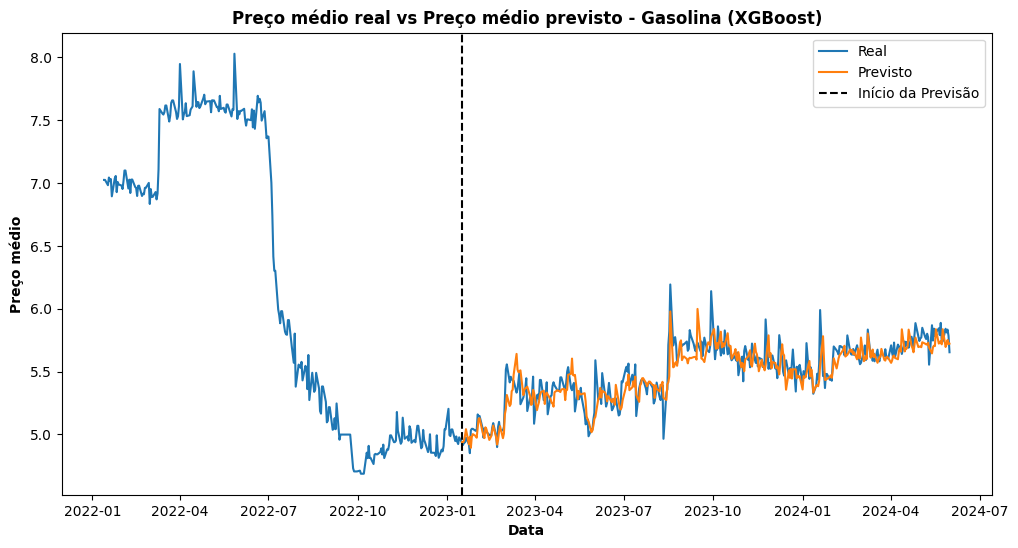

In [67]:
### DATAFRAME PARA AVALIAÇÃO DOS RESULTADOS

datas_pred_gasolina = pd.concat(fold['ds'] for fold in folds_teste_gasolina)  
resultados_gasolina = pd.DataFrame({
    'data': datas_pred_gasolina,
    'real': preco_gasolina_real,
    'prediction': preco_gasolina_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'GASOLINA']['ds'], y_gasolina, label='Real')
plt.plot(resultados_gasolina['data'], resultados_gasolina['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_gasolina['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Gasolina (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

## XGBOOST

In [61]:
## DEFINIÇÃO DOS PARÂMETROS DO MODELO E DO OBJETO DO XGBOOST REGRESSOR
params_xgb = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 1000
}

xgb_model_g = XGBRegressor(**params_xgb)
xgb_model_e = XGBRegressor(**params_xgb)

### ETANOL

In [62]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_etanol = []
preco_etanol_real = []
preco_etanol_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_etanol):
    X_etanol_train, X_etanol_test = X_etanol.iloc[train_index], X_etanol.iloc[test_index]
    y_etanol_train, y_etanol_test = y_etanol.iloc[train_index], y_etanol.iloc[test_index]

    ### TREINAMENTO DO MODELO
    xgb_model_e.fit(X_etanol_train, y_etanol_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_etanol = xgb_model_e.predict(X_etanol_test)
    rmse = mean_squared_error(y_etanol_test, y_pred_etanol, squared=False)
    print(f"RMSE do FOLD_{i}: {rmse}")
    rmse_scores_etanol.append(rmse)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_etanol_real.extend(y_etanol_test)
    preco_etanol_pred.extend(y_pred_etanol)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_etanol)}")

RMSE do FOLD_0: 0.07401570747430865
RMSE do FOLD_1: 0.09253512172344014
RMSE do FOLD_2: 0.11474128710660918
RMSE do FOLD_3: 0.0728128059110023

Média dos RMSEs: 0.08852623055384007


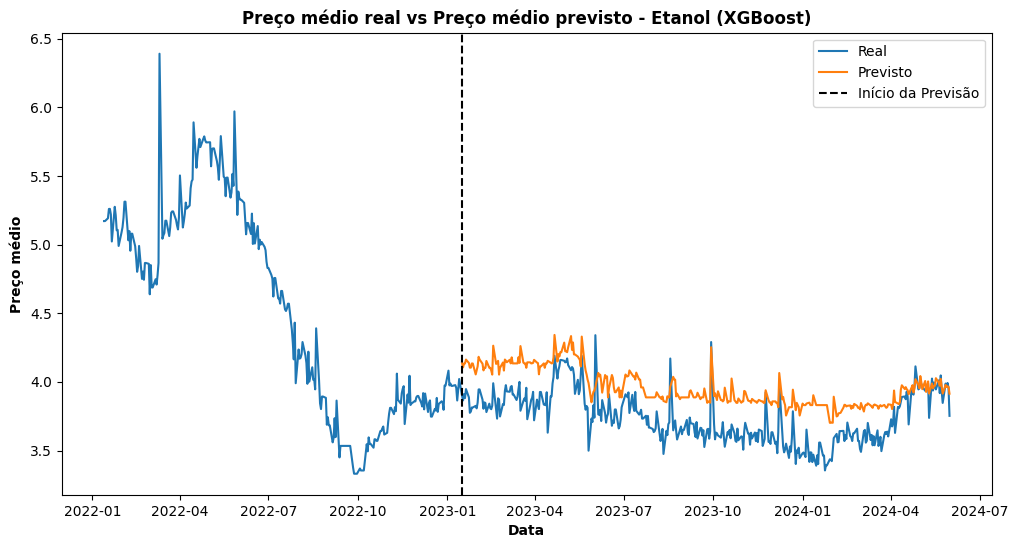

In [58]:
datas_pred_etanol = pd.concat(fold['ds'] for fold in folds_teste_etanol)  
resultados_etanol = pd.DataFrame({
    'data': datas_pred_etanol,
    'real': preco_etanol_real,
    'prediction': preco_etanol_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'ETANOL']['ds'], y_etanol, label='Real')
plt.plot(resultados_etanol['data'], resultados_etanol['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_etanol['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Etanol (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

### GASOLINA

In [172]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_gasolina = []
preco_gasolina_real = []
preco_gasolina_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_gasolina):
    X_gasolina_train, X_gasolina_test = X_gasolina.iloc[train_index], X_gasolina.iloc[test_index]
    y_gasolina_train, y_gasolina_test = y_gasolina.iloc[train_index], y_gasolina.iloc[test_index]

    ### TREINAMENTO DO MODELO
    xgb_model_g.fit(X_gasolina_train, y_gasolina_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_gasolina = xgb_model_g.predict(X_gasolina_test)
    rmse = mean_squared_error(y_gasolina_test, y_pred_gasolina, squared=False)
    print(f"RMSE do FOLD_{i}: {rmse}")
    rmse_scores_gasolina.append(rmse)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_gasolina_real.extend(y_gasolina_test)
    preco_gasolina_pred.extend(y_pred_gasolina)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_gasolina)}")

RMSE do FOLD_0: 0.1306098349406286
RMSE do FOLD_1: 0.12822221714689716
RMSE do FOLD_2: 0.10892347883769006
RMSE do FOLD_3: 0.08640481548087545

Média dos RMSEs: 0.11354008660152282


In [ ]:
### DATAFRAME PARA AVALIAÇÃO DOS RESULTADOS

datas_pred_gasolina = pd.concat(fold['ds'] for fold in folds_teste_gasolina)  
resultados_gasolina = pd.DataFrame({
    'data': datas_pred_gasolina,
    'real': preco_gasolina_real,
    'prediction': preco_gasolina_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'GASOLINA']['ds'], y_gasolina, label='Real')
plt.plot(resultados_gasolina['data'], resultados_gasolina['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_gasolina['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Gasolina (XGBoost)', fontweight='bold')
plt.legend()
plt.show()